## Prognose von Zeitreihen unter dem Einsatz von ARIMA, SARIMA Modelle und Holt-Winters Verfahren
Versuch die zukünftigen Temperaturwerte einer bestimmten Stadt mithilfe von Python vorherzusagen.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


#pd.options.display.max_rows = 5

In [2]:
%run sarima.py #laden von weiteren Bibliotheken und Funktionen

Ich nehme Dataset aus dem Notebook 'Time Series Analysis. Change of Local Climate'
https://github.com/okirsch/Time-Series-Analysis/blob/master/Time%20Series%20Analysis.%20Change%20of%20Local%20Climate..ipynb


Erst Daten lesen und die Struktur ansehen/anschauen.


In [3]:
df = pd.read_csv('weather_soltau.csv', index_col=0)
df


,Date.1,Precipitation,Temperature,Wind
Date,,,,
1947-07-21,1947-07-21,0.0,19.0,20.0
1947-07-22,1947-07-22,0.0,22.3,20.0
1947-07-23,1947-07-23,0.0,24.3,20.0
1947-07-24,1947-07-24,5.0,22.5,20.0
1947-07-25,1947-07-25,0.0,21.9,20.0
...,...,...,...,...
2020-11-26,2020-11-26,11.0,6.9,22.0
2020-11-27,2020-11-27,0.0,6.0,16.0
2020-11-28,2020-11-28,0.0,2.9,30.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26793 entries, 1947-07-21 to 2020-11-30
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date.1         26793 non-null  object 
 1   Precipitation  26793 non-null  float64
 2   Temperature    26793 non-null  float64
 3   Wind           26793 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.0+ MB


In [5]:
""" Index zu DateTime-Objekt umwandeln """
df.index = pd.to_datetime(df.index)


In [6]:
df.index.names = ['Datum'] # Indexname wechseln

In [7]:
""" Bilden von Spalten mit Angaben zum Wochentag, Woche, Monat und Jahr """

df['Wochentag'] = df.index.dayofweek
df['Woche'] = df.index.week
df['Monat'] = df.index.month
df['Jahr'] = df.index.year
df.tail()

,Date.1,Precipitation,Temperature,Wind,Wochentag,Woche,Monat,Jahr
Datum,,,,,,,,
2020-11-26,2020-11-26,11.0,6.9,22.0,3,48,11,2020
2020-11-27,2020-11-27,0.0,6.0,16.0,4,48,11,2020
2020-11-28,2020-11-28,0.0,2.9,30.0,5,48,11,2020
2020-11-29,2020-11-29,0.0,1.7,13.0,6,48,11,2020
2020-11-30,2020-11-30,21.0,1.6,28.0,0,49,11,2020


 Für die Prognose nehmen wir die letzte 5 Jahre 

In [8]:
data=pd.DataFrame(df[['Temperature', 'Monat', 'Jahr']]['2014-11-01':])
data.columns=['Temperatur', 'Monat', 'Jahr']
data.head()

,Temperatur,Monat,Jahr
Datum,,,
2014-11-01,13.0,11,2014
2014-11-02,12.3,11,2014
2014-11-03,13.5,11,2014
2014-11-04,10.9,11,2014
2014-11-05,8.3,11,2014


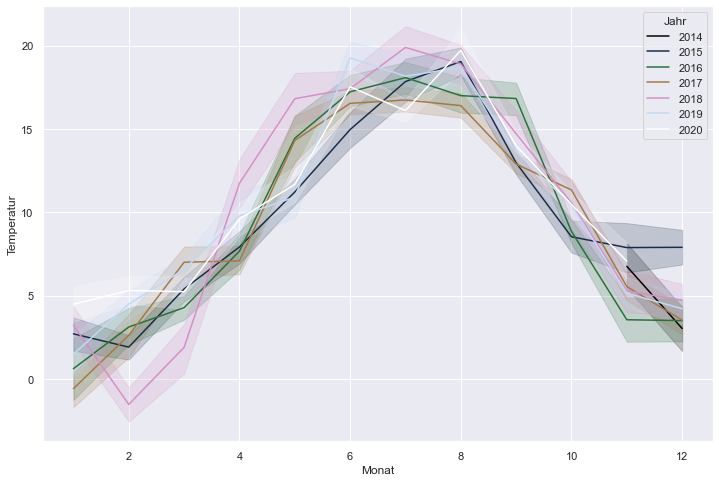

In [9]:
palette=sns.color_palette("cubehelix", as_cmap=True)
sns.set_theme() #grauer hintergrund

sns.lineplot(data=data, x="Monat", y="Temperatur", hue="Jahr", palette=palette);

Es sind ein paar kleinere Anomalien zu sehen: z.B. tiefe Werte im Jahr 2018. Schauen genauer nach.

### Prüfen nach Anomalien

In [10]:
sns.set_style(style = 'white')
sns.set(rc = {'figure.figsize': (12,8), 
             'axes.facecolor': 'white',
             'axes.grid': True,'grid.color': '.7',
             'axes.linewidth': 1.0, 
             'grid.linestyle': u'-'}, font_scale = 1.0)
custom_colors = [ '#013766', '#a2adc3', '#bedcda','#c7aabc','#f2e2dd']
sns.set_palette(custom_colors)

In [11]:
anomal = validate_series(data.Temperatur)

In [12]:
""" Schauen nach Maximum und Minimum """
anomal.describe()

count    2222.000000
mean        9.956571
std         6.713299
min       -10.100000
25%         4.700000
50%         9.650000
75%        15.300000
max        28.000000
Name: Temperatur, dtype: float64

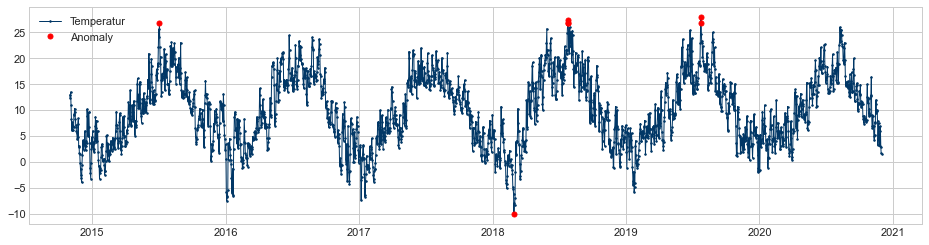

In [13]:
threshold_anomal = ThresholdAD(high=26, low=-9)  #suchen der Werte größer als 26 Grad und kleiner als -9 Grad
anomalies = threshold_anomal.detect(anomal)
plot(anomal, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");

In [14]:
anomalies[anomalies]

Datum
2015-07-04    True
2018-02-28    True
2018-07-25    True
2018-07-26    True
2018-07-27    True
2019-07-24    True
2019-07-25    True
Name: Temperatur, dtype: bool

### Korregieren von einigen Anomalien für eine bessere Prognose

In [15]:
data['2018-02-27':'2018-03-02']

,Temperatur,Monat,Jahr
Datum,,,
2018-02-27,-6.1,2,2018
2018-02-28,-10.1,2,2018
2018-03-01,-7.9,3,2018
2018-03-02,-8.2,3,2018


In [16]:
data.loc['2018-02-28'] = data.loc['2018-03-01']

In [17]:
data['2019-07-23':'2019-07-27']

,Temperatur,Monat,Jahr
Datum,,,
2019-07-23,23.0,7.0,2019.0
2019-07-24,26.8,7.0,2019.0
2019-07-25,28.0,7.0,2019.0
2019-07-26,24.7,7.0,2019.0
2019-07-27,23.0,7.0,2019.0


In [18]:
data.loc['2019-07-25'] = data.loc['2019-07-24']

In [19]:
data.describe(include='all')

,Temperatur,Monat,Jahr
count,2222.000000,2222.000000,2222.000000
mean,9.957021,6.582808,2017.369487
std,6.709097,3.464639,1.764073
min,-8.200000,1.000000,2014.000000
25%,4.700000,4.000000,2016.000000
50%,9.650000,7.000000,2017.000000
75%,15.300000,10.000000,2019.000000
max,27.400000,12.000000,2020.000000


Ich nehme die mittleren Werte für Woche

In [20]:
df['2014-11-01': '2014-11-07'] # 3.11.2014 ist Montag, fangen da an

,Date.1,Precipitation,Temperature,Wind,Wochentag,Woche,Monat,Jahr
Datum,,,,,,,,
2014-11-01,2014-11-01,0.0,13.0,20.0,5,44,11,2014
2014-11-02,2014-11-02,8.0,12.3,29.0,6,44,11,2014
2014-11-03,2014-11-03,11.0,13.5,46.0,0,45,11,2014
2014-11-04,2014-11-04,82.0,10.9,30.0,1,45,11,2014
2014-11-05,2014-11-05,10.0,8.3,27.0,2,45,11,2014
2014-11-06,2014-11-06,0.0,6.1,16.0,3,45,11,2014
2014-11-07,2014-11-07,0.0,6.2,35.0,4,45,11,2014


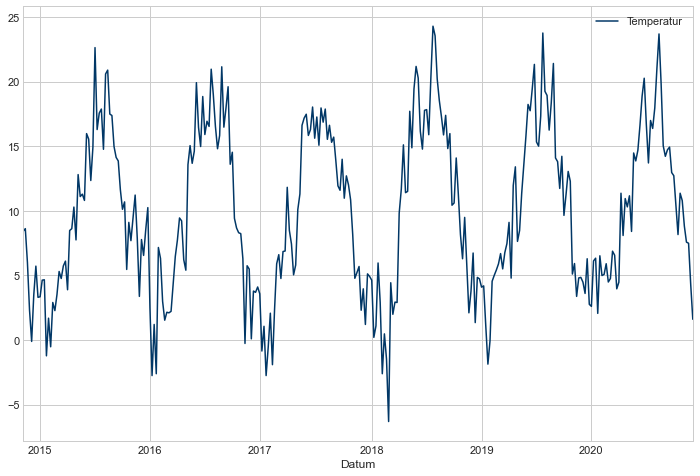

In [21]:
wochen = pd.DataFrame(data['Temperatur']['2014-11-03':].resample('W').mean())
wochen.plot();

### Dekomposition


Ein Blick auf die verschiedenen Komponenten der Zeitreihe:

In [22]:
data_series = validate_series(wochen.Temperatur)

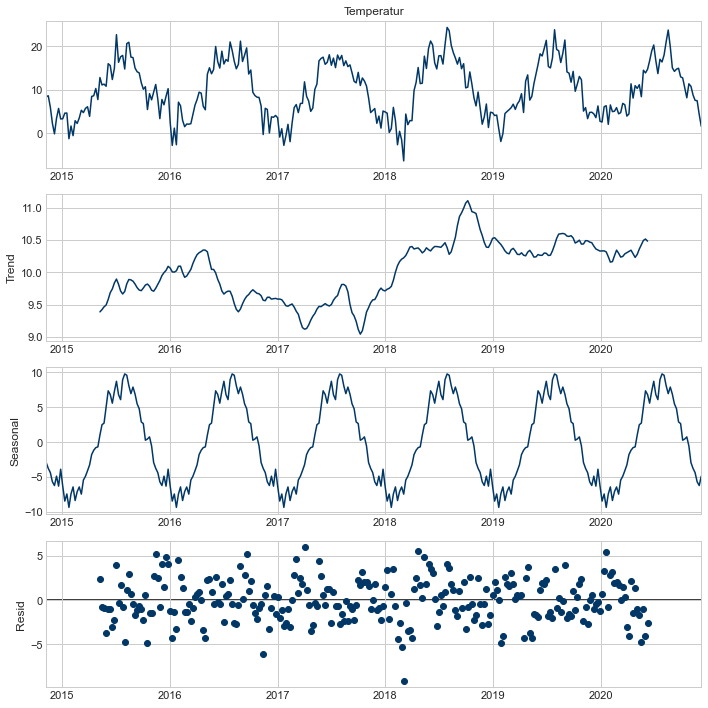

In [23]:
dekompose = seasonal_decompose(data_series, model='additive', freq=52) #ряд и сезонность плюсуются

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
dekompose.plot();#.suptitle('Additive')

Eine Zeitreihe setzt sich zusammen aus einem Trend, einer saisonalen Komponente und den Residuen. 

Diese Zeitreihe ist nicht stazionär, da sich die Mittelwerte nach Saison ändern und es ein leicht steigender Trend zu beobachten ist.

### Dickey-Fuller-Test

Wir ziehen die Daten dem Dickey-Fuller-Test unter, um die Stationarität zu prüfen:

In [24]:
print(" T-Statistik: ",adfuller(data_series)[0], " P-Value: ", adfuller(data_series)[1])        
for key, value in adfuller(data_series)[4].items():
         print("\t",key, ": ", value)     

 T-Statistik:  -7.975318217722297  P-Value:  2.712211963276004e-12
	 1% :  -3.4523371197407404
	 5% :  -2.871222860740741
	 10% :  -2.571929211111111


P-Value weisst mit 95% Sicherheit auf Stationarität, aber die T-Statistik liegt zwischen 1% und 5% kritischen Werten, die Nullhypothese (nicht stationäre Zeitreihe) ist somit anzunehmen.

### ARIMA


AR (p) Autoregressiv

Eine abhängige Beziehung zwischen einer aktuellen Beobachtung und einer aus einem früheren Zeitraum. Eine autoregressive Ordnung von 2 gibt beispielsweise an, dass die Werte der Zeitreihe, die zwei Zeitperioden zurückliegt, für die Vorhersage der aktuellen Werte verwendet wird

I (d) Differenzierung

Subtrahieren einer Beobachtung von der Beobachtung im vorherigen Zeitschritt. Mithilfe der Differenzierung werden die Effekte der Trends entfernt. Die Ordnung der Differenzierung entspricht dem Grad des Trends der Zeitreihe: Differenzierung erster Ordnung erklärt lineare Trends, Differenzierung zweiter Ordnung erklärt quadratische Trends usw

MA (q) Gleitender Durchschnitt.

Gibt an, wie Abweichungen vom Mittelwert der Zeitreihe für zurückliegende Werte zum Vorhersagen der aktuellen Werte verwendet werden. Ordnungen des gleitenden Durchschnitts von 1 und 2 geben beispielsweise an, dass beim Vorhersagen der aktuellen Werte der Zeitreihe Abweichungen vom Mittelwert der Zeitreihe von den beiden letzten Zeitperioden berücksichtigt werden sollen.


#### Dataset in Train and Test aufteilen.

In [25]:
df_fit = wochen
train = df_fit[:'2020-10-01']
test = df_fit['2020-10-01':]
test.head()

,Temperatur
Datum,
2020-10-04,12.714286
2020-10-11,10.385714
2020-10-18,8.157143
2020-10-25,11.357143
2020-11-01,10.785714


In [26]:
model_arima = auto_arima(train,trace=True, suppress_warnings=True,\
                   error_action='ignore', stepwise=True)
model_arima

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1544.380, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2020.156, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1554.128, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1796.882, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2399.111, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1543.202, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1705.245, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1542.236, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1543.693, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1545.697, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1548.922, Time=0.07 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 1.053 seconds


ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [27]:
model_arima = ARIMA(train, order=(1, 0, 1))
results_arima = model_arima.fit()

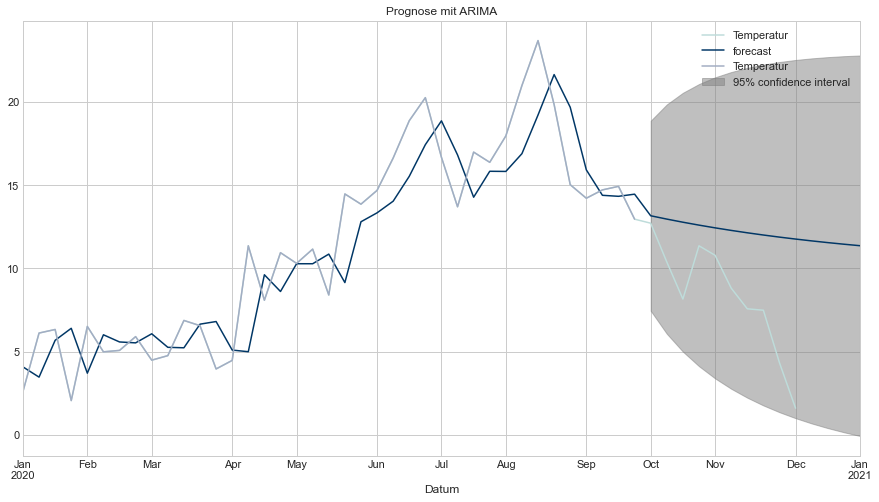

In [28]:
ax = wochen['2020':].plot(figsize =(15,8), color='#bedcda', title='Prognose mit ARIMA')
results_arima.plot_predict( '2020', '2020-12-31',  alpha=0.05, ax=ax);


### SARIMA

In unseren Daten ist eindeutig  *Saisonalität*  zu erkennen, deswegen probieren wir das SARIMA Verfahren.

Das SARIMA Modell wird mit
SARIMA (p,d,q)(P, D,Q,m) beschrieben, wobei m die Länge einer Saison angibt. Der zusätzliche Teil in diesem Modell betrachtet die Werte der Zeitreihe sowie Vorhersage-Fehler, welche
vor genau einer Saison aufgezeichnet wurden. Dieser Teil bildet die Saisonalität des Modells ab.

Erst schauen nach Autokorrelation, um Parameter besser anzupassen

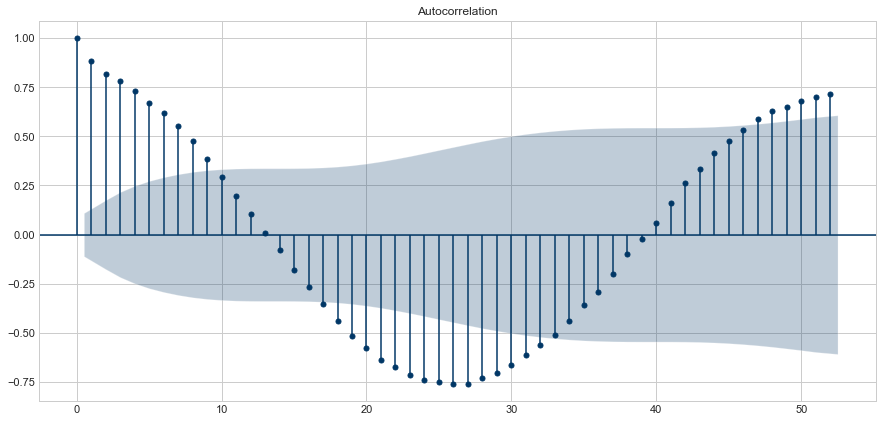

In [29]:
plt.rcParams.update({'figure.figsize': (15,7)})
plot_acf(df_fit.Temperatur, lags=52)
plt.show()

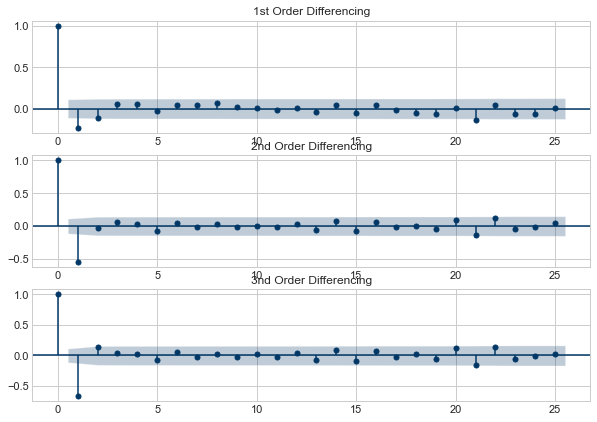

In [30]:
fig = plt.figure(figsize=(10, 7))
 
ax1 = fig.add_subplot(311)
fig = plot_acf(train.diff().dropna(), ax=ax1, 
               title="1st Order Differencing")
ax2 = fig.add_subplot(312)
fig = plot_acf(train.diff().diff().dropna(), ax=ax2, 
               title="2nd Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(train.diff().diff().diff().dropna(), ax=ax3, 
               title="3nd Order Differencing")

Es ist nicht einfach, Parameter zu bestimmen, nutzen die automatische Auswahl:

In [31]:
model_sarima = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True,\
                   error_action='ignore', stepwise=True) # m=52 weil 52 Wochen im Jahr
model_sarima

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1547.016, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2020.156, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1556.005, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1778.624, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2399.111, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1546.316, Time=0.37 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1544.380, Time=0.14 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1546.332, Time=0.53 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1543.202, Time=0.18 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=1545.166, Time=0.40 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=1545.153, Time=0.30 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=1545.640, Time=0.98 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1705.245, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1542.236, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [32]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12))

results_sarima = mod.fit()

print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9839      0.011     89.551      0.000       0.962       1.005
ma.L1         -0.2930      0.059     -5.001      0.000      -0.408      -0.178
sigma2         8.6916      0.673     12.912      0.000       7.372      10.011


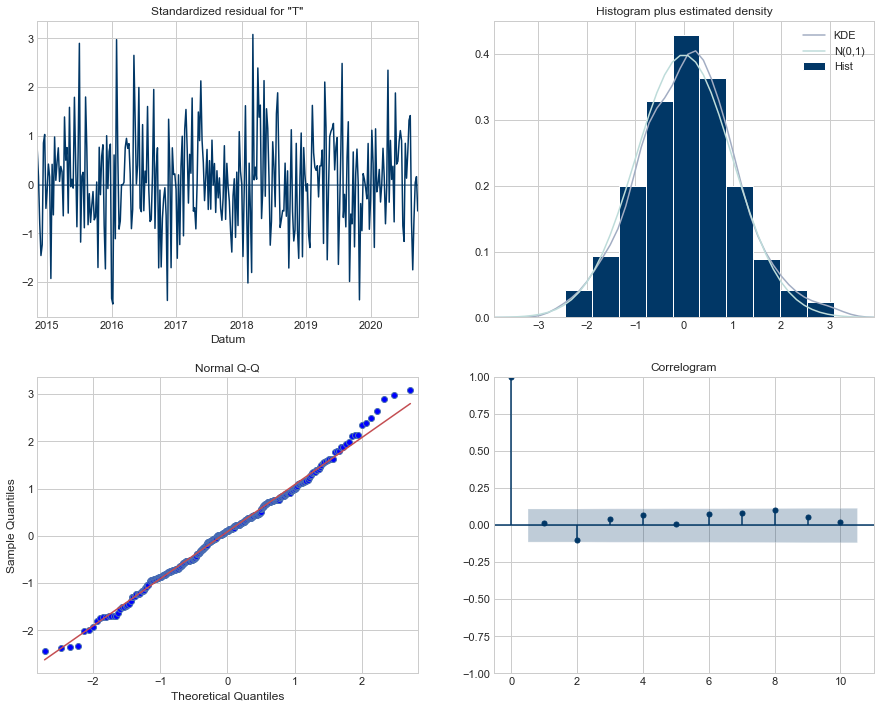

In [33]:
results_sarima.plot_diagnostics(figsize=(15, 12))
plt.show()

Die Residuen-Diagnostik: das Histogram zeigt, dass die Residuen fast normalverteilt sind. Der vorliegende Quantil-Quantil Plot spricht für eine Verteilung der Fehlerterme die in den unteren Quantilen mit denen der Normalverteilung übereinstimmt, in den hohen jedoch größere Werte aufweißt. Correlogram weisst auf Stationarität der Residuen-Reihe.

In [34]:
predict_sarima=results_sarima.get_prediction()
predict_sarima.predicted_mean[:10]

Datum
2014-11-09    0.000000
2014-11-16    8.123581
2014-11-23    8.342226
2014-11-30    6.585039
2014-12-07    3.517610
2014-12-14    0.951560
2014-12-21    2.677161
2014-12-28    4.732282
2015-01-04    3.666373
2015-01-11    3.383699
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [35]:
predict_sarima=results_sarima.get_prediction(start='2020', end='2020-12-30')

In [36]:
predict_sarima.predicted_mean[10:]

2020-03-15     4.669695
2020-03-22     6.115501
2020-03-29     6.321948
2020-04-05     4.586118
2020-04-12     4.432879
2020-04-19     9.145255
2020-04-26     8.265662
2020-05-03     9.981935
2020-05-10    10.040616
2020-05-17    10.649999
2020-05-24     8.923650
2020-05-31    12.612563
2020-06-07    13.268916
2020-06-14    14.033662
2020-06-21    15.600013
2020-06-28    17.608481
2020-07-05    19.154286
2020-07-12    17.129834
2020-07-19    14.483791
2020-07-26    15.978636
2020-08-02    15.992183
2020-08-09    17.091706
2020-08-16    19.506247
2020-08-23    22.079048
2020-08-30    20.177821
2020-09-06    16.294670
2020-09-13    14.594424
2020-09-20    14.441741
2020-09-27    14.545057
2020-10-04    13.213286
2020-10-11    13.000078
2020-10-18    12.790310
2020-10-25    12.583927
2020-11-01    12.380874
2020-11-08    12.181098
2020-11-15    11.984545
2020-11-22    11.791163
2020-11-29    11.600903
2020-12-06    11.413712
2020-12-13    11.229541
2020-12-20    11.048343
2020-12-27    10

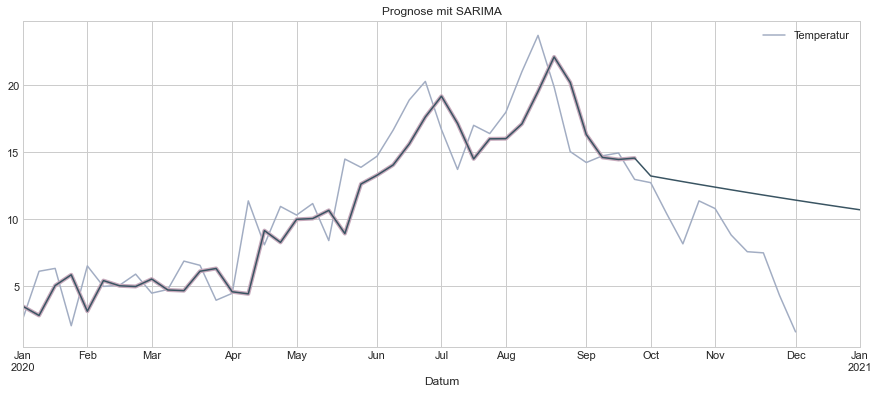

In [37]:
ax = wochen['2020-01-01':].plot(figsize=(15,6),color = '#a2adc3', title="Prognose mit SARIMA" )
results_sarima.fittedvalues['2020-01-01':].plot(ax=ax, linewidth=4, color = '#c7aabc')
predict_sarima.predicted_mean['2020-01-01':].plot(ax=ax,  color ='#395462')
plt.show()

### Genauigkeit von SARIMA-Model

#### Train

Residuen Daten sind stationär

In [38]:
predict_sarima=results_sarima.get_prediction(start='2014-11-16')
metrics(train['2014-11-16':], predict_sarima.predicted_mean)

Test für Stationarität:
	T-Statistik = -13.511
	P-Walue = 0.000
Kritische Werte :
	1%: -3.451973573620699 - Daten sind  stationär mit einer Wahrscheinlichkeit von  99% 
	5%: -2.8710633193086648 - Daten sind  stationär mit einer Wahrscheinlichkeit von  95% 
	10%: -2.5718441306100512 - Daten sind  stationär mit einer Wahrscheinlichkeit von  90% 
MAD: 2.3183
MSE: 8.7056
MAPE: 0.252
MPE: -0.0322
Standartfehler: 2.9505


#### Test

In [39]:
predict_sarima=results_sarima.get_prediction(start='2020-10-01', end='2020-11-30')
metrics(test, predict_sarima.predicted_mean)

Test für Stationarität:
	T-Statistik = 1.725
	P-Walue = 0.998
Kritische Werte :
	1%: -4.9386902332361515 - Daten sind не stationär mit einer Wahrscheinlichkeit von  99% 
	5%: -3.477582857142857 - Daten sind не stationär mit einer Wahrscheinlichkeit von  95% 
	10%: -2.8438679591836733 - Daten sind не stationär mit einer Wahrscheinlichkeit von  90% 
MAD: 3.974
MSE: 23.1143
MAPE: 1.0469
MPE: -1.0469
Standartfehler: 4.8077


MSE für Test-Daten ist schlechter: 23.1143 gegen 8.7056 für Train-Daten

### Holt-Winters Verfahren

Bei diesem Verfahren können auch Zeitreihen, die saisonale Schwankungen enthalten, prognostiziert werden.

Das Holt Winters Verfahren kann Saisonalität auf zwei verschiedene
Arten modelliert werden: additive und multiplutakive. Wir nehmen die additive, da in unserem Beispiel eine fast gleich bleibende Amplitude des saisonalen Verhaltens erkennbar ist. Und wir haben negative Werte. Daher wird die saisonale Komponente in *additiver* Form berücksichtigt.

In [40]:
model_hw =  ExponentialSmoothing(train, seasonal_periods = 12, trend='add', seasonal='add').fit()

In [41]:
#model_hw.params

Prognose für 8 Wochen:

In [42]:
model_hw.forecast(8)

2020-10-04    12.458522
2020-10-11    13.000808
2020-10-18    14.136807
2020-10-25    13.988236
2020-11-01    14.006810
2020-11-08    14.176040
2020-11-15    13.899664
2020-11-22    13.642522
Freq: W-SUN, dtype: float64

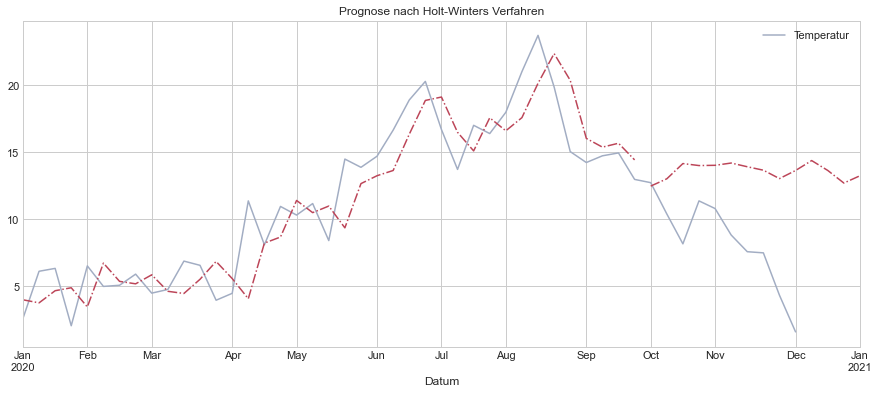

In [43]:
ax = wochen['2020':].plot(figsize =(15,6), color = '#a2adc3', title='Prognose nach Holt-Winters Verfahren')
model_hw.fittedvalues['2020':].plot(ax=ax,style = '-.', color='#bc4558')
model_hw.forecast(14).plot(ax=ax, style = '-.', color = '#bc4558', label = 'Holt-Winters');



### Genauigkeit von Holt-Winters-Model

#### Train

In [44]:
metrics(train, model_hw.fittedvalues)

Test für Stationarität:
	T-Statistik = -17.177
	P-Walue = 0.000
Kritische Werte :
	1%: -3.4518314994261337 - Daten sind  stationär mit einer Wahrscheinlichkeit von  99% 
	5%: -2.8710009653519166 - Daten sind  stationär mit einer Wahrscheinlichkeit von  95% 
	10%: -2.571810878948318 - Daten sind  stationär mit einer Wahrscheinlichkeit von  90% 
MAD: 2.2992
MSE: 8.36
MAPE: 0.3172
MPE: -0.0764
Standartfehler: 2.8914


#### Test

In [45]:
metrics(test, model_hw.forecast(len(test)))

Test für Stationarität:
	T-Statistik = 5.990
	P-Walue = 1.000
Kritische Werte :
	1%: -5.354256481481482 - Daten sind не stationär mit einer Wahrscheinlichkeit von  99% 
	5%: -3.6462381481481483 - Daten sind не stationär mit einer Wahrscheinlichkeit von  95% 
	10%: -2.901197777777778 - Daten sind не stationär mit einer Wahrscheinlichkeit von  90% 
MAD: 5.3259
MSE: 38.6643
MAPE: 1.3322
MPE: -1.3282
Standartfehler: 6.2181


MSE für Test-Daten ist schlechter: 38.6643 gegen 8.36 für Train-Daten 

### Graphische Darstellung allen Modellen

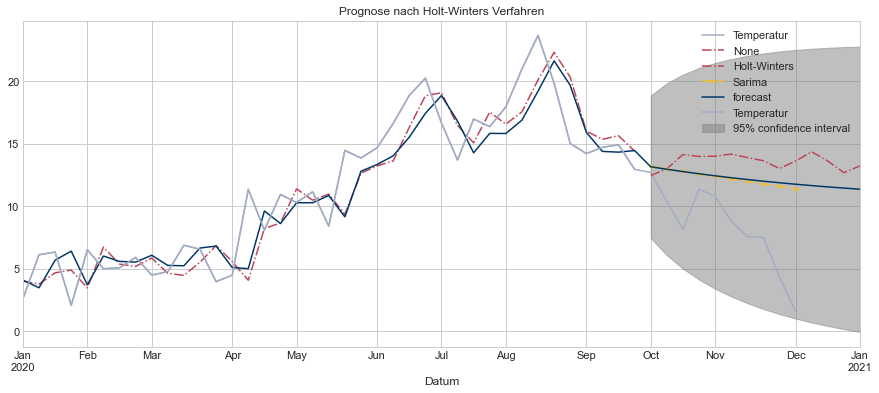

In [46]:
ax = wochen['2020':].plot(figsize =(15,6), color = '#a2adc3', title='Prognose nach Holt-Winters Verfahren')
model_hw.fittedvalues['2020':].plot(ax=ax,style = '-.', color='#bc4558')
model_hw.forecast(14).plot(ax=ax, style = '-.', color = '#bc4558', label = 'Holt-Winters' )
predict_sarima.predicted_mean.plot(ax=ax, style = '.-.', color ='#f0bf30',label = 'Sarima')

results_arima.plot_predict( '2020', '2020-12-31',  alpha=0.05, ax=ax);

Model Sarima weisst bessere Ergebnisse visuell, als auch nach MSE-Wert für Test-Daten:  23.1143 gegen 38.6643 für  Holt-Winters-Model. 
